# [IAPR][iapr]: Lab 2 ‒  Object description

**Group ID:** 05

**Author 1 (sciper):** Lavinia Schlyter (284566)
**Author 2 (sciper):** Simon Gilgien (253797)
**Author 3 (sciper):** Cengizhan Bektas (350828)

**Release date:** 25.03.2022  
**Due date:** 08.04.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [2]:
# import additionnal libraries
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import skimage.io
from skimage.filters import threshold_otsu 

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

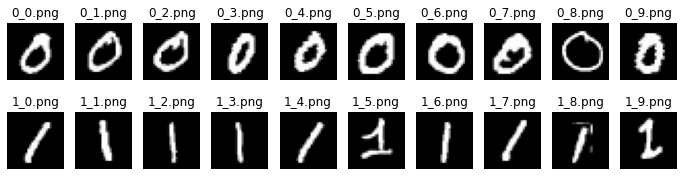

In [3]:
def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')


# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors (15 pts)

The first step that we do is to binarize the image by thresholding. Since the background is very dark, we can choose a low threshold of 50.

Then we extract the contours of the binarized image. We do this using OpenCV's `findContours` method. We pass the flags `cv2.RETR_EXTERNAL` since we only care about the outermost contour of each shape, and `cv2.CHAIN_APPROX_NONE` since we don't want to skip points of the contour in the middle of straight lines, as it would mean that the contour is not scanned at a constant speed.

The next step is to select the longest contour found in the shape. Due to noise, multiple contours might have been returned. We're only interested in the longest contour as it will (most likely) be the digit. We also convert it to the complex representation $u = x + jy$.

After that we interpolate a fixed number of points on the contour. Due to different size and/or geometry, the contour might have a varying number of points. This is inefficient to compute a FFT and the resulting Fourier coefficient would not be directly comparable. To solve this issue we take a fixed number of 64 points regularly spaced on the contour (this is actually an approximation as we consider a pixel edge to be the same length as a pixel diagonal, but it turns out to be good enough). The number 64 is chosen because the FFT computation is most efficient when the number of points is a power of 2, and 64 points can represent most contours very precisely. The interpolation is based on linear segments between adjacent points of the original contour.

Finally, we compute the fast Fourier transform of the resulting contour. To be invariant to translations, we discard the DC component of the Fourier transform. To be invariant to rotations and arbitrary starting point on the contour, we ignore the phase information and only take the magnitude into consideration. Finally, to be invariant to scaling, we must only consider ratio between the different components. We know that good candidates are the low frequency components. By trial and error, we choose to use the ratio between the first two non-DC components of positive frequency divided by the first non-DC component of negative frequency (we only consider the magnitude of each component). Since the input sequence is complex, terms of positive and negative frequencies are different.

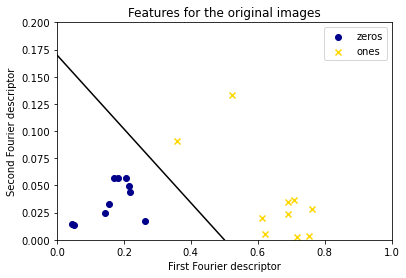

In [4]:
# Add your implementation and discussion

def interpolate_contour(contour, length):
    """Given a contour, interpolate a contour of a given length"""
    if len(contour) == 1:
        return [contour[0] for x in range(length)]
    
    new_contour = []
    for i in range(length):
        index = i*len(contour)/length
        
        # Fraction of the segment between the last original point and the next one
        k = index - int(index)
        # Index of the last original point before the interpolated point
        index = int(index)
        
        if index == len(contour) - 1:
            # Linear interpolation
            new_contour.append(contour[-1] * (1-k) + contour[0] * k)
            
        else:
            # Linear interpolation
            new_contour.append(contour[index] * (1-k) + contour[index+1] * k)
            
    return new_contour
        
    

def fourier_descriptors(img):
    
    # thresholding
    img = (img > 50).astype(np.uint8)
    
    # extract contours
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # take the longest contour
    contour = max(contours, key=lambda c: len(c))
    
    # convert to complex representation
    contour = [x[0][0]+x[0][1]*1j for x in contour]
    
    # interpolate to a fixed lenght
    contour = interpolate_contour(contour, 64)
    
    # take the fourier transform
    fourier_transform = np.fft.fft(contour)
    
    # return the magnitude of the second and third terms, normalized by the magnitude of the last term
    return (abs(x)/abs(fourier_transform[-1]) for x in fourier_transform[1:3])


# Plot results

X = []
Y = []
for im in zeros_im:
    x, y = fourier_descriptors(im)
    X.append(x)
    Y.append(y)
    
plt.scatter(X, Y, marker='o', color='darkblue')

X = []
Y = []
for im in ones_im:
    x, y = fourier_descriptors(im)
    X.append(x)
    Y.append(y)
    
plt.scatter(X, Y, marker='x', color='gold')
plt.legend(["zeros", "ones"])

# Separation line
plt.plot([0, 0.5], [0.17, 0], color='black')

plt.title("Features for the original images")
plt.xlabel("First Fourier descriptor")
plt.ylabel("Second Fourier descriptor")
_ = plt.axis([0, 1, 0, 0.2])

We can see that the two groups are clearly separable in 2 regions. We can also see 2 outliers in the group of ones. This is due to the fact that 2 samples of digit 1 have a different shape (`1_5.png` and `1_9.png`, which have a hook and a base line). It is therefore expectable that those sample will have different Fourier descriptors. However those outliers are still separable from the zeros.

#### Invariance to geometrical transformations

We apply some geometrical transformations on every image to test invariance. We do the transformations using OpenCV's `warpAffine` and `getRotationMatrix2D` (which also provides scaling). We visualize each image and plot the Fourier descriptors for each group of images.

**Translation**

We use a translation of (2, 3) pixels in the (x, y) directions.

**Rotation**

We use a rotation of 30° centered on the center of the image.

**Scaling**

We use a scaling factor of 1.2 centered on the center of the image.

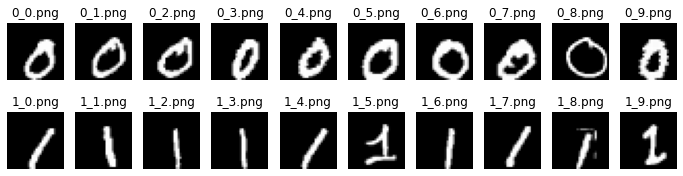

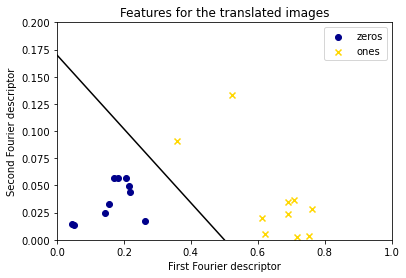

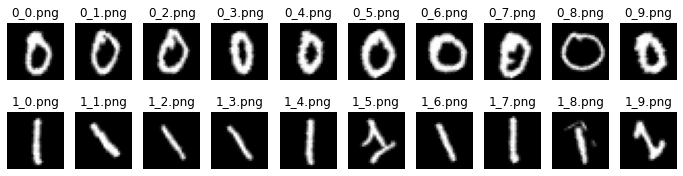

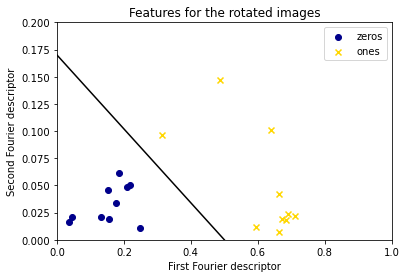

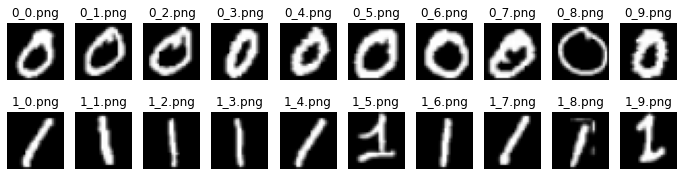

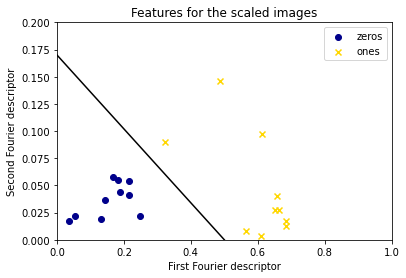

In [5]:
# translate the image by a translation vector [2, 3]
def translate(img):
    T = np.float32([[1, 0, 2], [0, 1, 3]])
    return cv2.warpAffine(im, T, im.shape)

# Rotate the image by 30 degrees counter-clockwise
def rotate(img):
    x, y = img.shape
    angle = 30
    T = cv2.getRotationMatrix2D((x/2, y/2), angle, 1)
    return cv2.warpAffine(im, T, im.shape)

# Scale the image by a factor 1.2
def scale(img):
    x, y = img.shape
    scale = 1.2
    T = cv2.getRotationMatrix2D((x/2, y/2), 0, scale)
    return cv2.warpAffine(im, T, im.shape)


# Plot translated images and their features
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
X0, Y0, X1, Y1 = [], [], [], []

for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    im = translate(im)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
    x, y = fourier_descriptors(im)
    X0.append(x)
    Y0.append(y)
    
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    im = translate(im)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
    x, y = fourier_descriptors(im)
    X1.append(x)
    Y1.append(y)
    
fig = plt.figure()
plt.scatter(X0, Y0, marker='o', color='darkblue')
plt.scatter(X1, Y1, marker='x', color='gold')
plt.legend(['zeros', 'ones'])

# Separation line
plt.plot([0, 0.5], [0.17, 0], color='black')

plt.xlabel("First Fourier descriptor")
plt.ylabel("Second Fourier descriptor")
plt.axis([0, 1, 0, 0.2])
plt.title("Features for the translated images")

# Plot rotated images and their features
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
X0, Y0, X1, Y1 = [], [], [], []
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    im = rotate(im)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
    x, y = fourier_descriptors(im)
    X0.append(x)
    Y0.append(y)
    
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    im = rotate(im)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
    x, y = fourier_descriptors(im)
    X1.append(x)
    Y1.append(y)
    
fig = plt.figure()
plt.scatter(X0, Y0, marker='o', color='darkblue')
plt.scatter(X1, Y1, marker='x', color='gold')
plt.legend(['zeros', 'ones'])

# Separation line
plt.plot([0, 0.5], [0.17, 0], color='black')

plt.xlabel("First Fourier descriptor")
plt.ylabel("Second Fourier descriptor")
plt.axis([0, 1, 0, 0.2])
plt.title("Features for the rotated images")


# Plot scaled images and their features
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
X0, Y0, X1, Y1 = [], [], [], []
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    im = scale(im)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
    x, y = fourier_descriptors(im)
    X0.append(x)
    Y0.append(y)
    
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    im = scale(im)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
    x, y = fourier_descriptors(im)
    X1.append(x)
    Y1.append(y)
    
fig = plt.figure()
plt.scatter(X0, Y0, marker='o', color='darkblue')
plt.scatter(X1, Y1, marker='x', color='gold')
plt.legend(['zeros', 'ones'])

# Separation line
plt.plot([0, 0.5], [0.17, 0], color='black')

plt.xlabel("First Fourier descriptor")
plt.ylabel("Second Fourier descriptor")
plt.axis([0, 1, 0, 0.2])
_ = plt.title("Features for the scaled images")

We can see that the same line separates the 2 groups in every case, and that that the clusters are at the same location. This confirms the fact that our descriptors are invariant to translations, rotations and scaling. The differences are due to the fact that the binarization and contour detection introduce some noise, so the considered contour is not an exact translation, rotation or scaling of the original one.

### 1.3 Additional method (5 pts)

As an additonal method, we decided to use a region based mehtod.

The idea is to use the difference in geometry between the digit one and two. More specifically we will use the notion of compacity which is defined as $$C = \frac{P^2}{A}$$ with:
- P: perimeter
- A: the area

Steps:

- Close to fill some small holes
- Find the contours 
- Fill in the contours to compute the filled area
- Compute the perimeter using the contours
- Compute the compacity 


Plot combination of the previous values to see if they enable distinguishing both digits.

In [6]:

#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')

# List to save values
ZERO_AREAS = []
ZERO_COMPACITY = []
ONE_AREAS = []
ONE_COMPACITY = []
ZERO_PERIMETER = []
ONE_PERIMETER = []

# Go through each image
for i, (z_im, o_im) in enumerate(zip(zeros_im, ones_im)):
    
    # Close image to get rid of small holes
    k = np.ones((3,3), dtype='uint8')
    z_im_close = cv2.morphologyEx(z_im, cv2.MORPH_CLOSE, k)
    o_im_close = cv2.morphologyEx(o_im, cv2.MORPH_CLOSE, k)

    
    # Fill in the blanks (a zero will have all its interior filled)
    all_contours_zero = cv2.findContours(z_im_close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]
    all_contours_one = cv2.findContours(o_im_close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]
    
    mask_zero = np.zeros(z_im_close.shape[:2], np.uint8)
    mask_one = np.zeros(o_im_close.shape[:2], np.uint8)
    cv2.drawContours(mask_zero, all_contours_zero, -1, 255, -1)
    cv2.drawContours(mask_one, all_contours_one, -1, 255, -1)
    
    # Compute area
    area_zero = cv2.contourArea(all_contours_zero[0])
    area_one = cv2.contourArea(all_contours_one[0])
    
    # Compute perimeter
    z_contour = skimage.measure.find_contours(mask_zero)
    o_contour = skimage.measure.find_contours(mask_one)
    z_per = len(z_contour[0])
    o_per = len(o_contour[0])
    
    # Compute compacity 
    z_compacity = z_per**2/area_zero
    o_compacity = o_per**2/area_one
    
    # Store data
    ZERO_AREAS.append(area_zero)
    ONE_AREAS.append(area_one)
    ZERO_COMPACITY.append(z_compacity)
    ONE_COMPACITY.append(o_compacity)
    ZERO_PERIMETER.append(z_per)
    ONE_PERIMETER.append(o_per)



Below we show the output for some of the steps of the above algorithm [grayscaled]

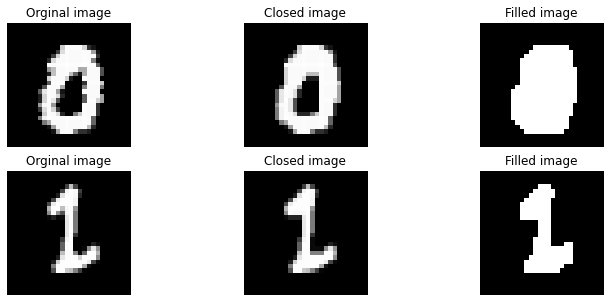

In [7]:
# Plot images
fig, axes = plt.subplots(2, 3, figsize=(12, 5))
for ax, im, nm in zip(axes[0], [z_im, z_im_close, mask_zero], ["Orginal image", "Closed image", "Filled image"]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], [o_im, o_im_close, mask_one], ["Orginal image", "Closed image", "Filled image"]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

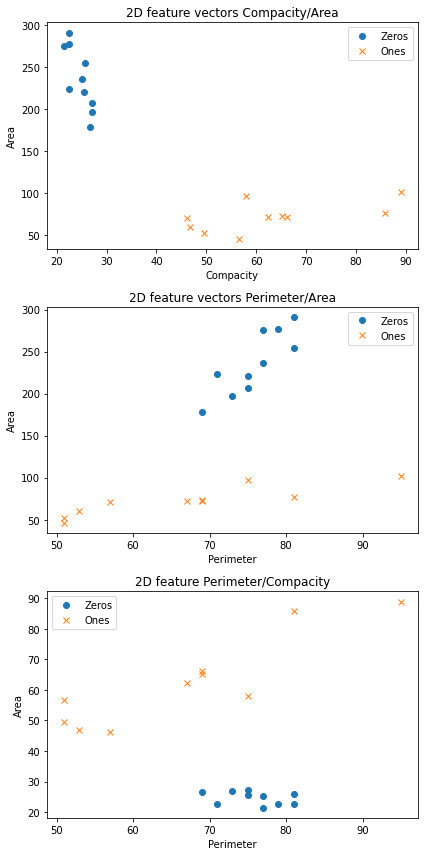

In [8]:

fig, ax = plt.subplots(3, 1, figsize=(6, 12))
ax[0].plot(ZERO_COMPACITY, ZERO_AREAS, "o",ONE_COMPACITY, ONE_AREAS, "x" )
ax[0].set_title('2D feature vectors Compacity/Area')
ax[0].set_ylabel('Area');
ax[0].set_xlabel('Compacity');
ax[0].legend(['Zeros', 'Ones'])

ax[1].plot(ZERO_PERIMETER, ZERO_AREAS, "o",ONE_PERIMETER, ONE_AREAS, "x" )
ax[1].set_title('2D feature vectors Perimeter/Area')
ax[1].set_ylabel('Area');
ax[1].set_xlabel('Perimeter');
ax[1].legend(['Zeros', 'Ones'])

ax[2].plot(ZERO_PERIMETER, ZERO_COMPACITY, str("o"),ONE_PERIMETER, ONE_COMPACITY, "x")
ax[2].set_title('2D feature Perimeter/Compacity')
ax[2].set_ylabel('Area');
ax[2].set_xlabel('Perimeter');
ax[2].legend(['Zeros', 'Ones'])


fig.tight_layout()


From the plots above we note that all the 2D feature vectors allow for classifying accurately both digits. That is, we can trace a line that separates both labels. The best discriminators are the compacity and the area (but the later is not scaling-invariant). The perimeter does not allow to separate the two groups.

It is important to note that the algorithm used is successful because we have an apriori idea of what needs to be classfied. That is, we know that for a given size of digit 0&1, a filled zero will have a greater area

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

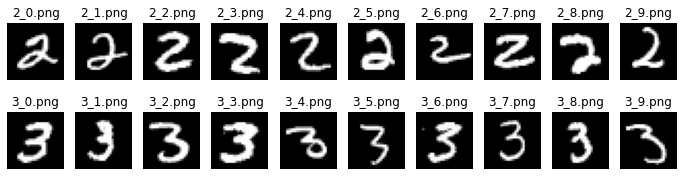

In [9]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

As we did in part 1, we will firstly binarize the image. For this, we will use thresholding with the otsu method to be more precise.

This time we will set the number of points of the contour to 128. As mentioned before, the FFT computation is most efficient when the number of points is a power of 2, and the mean of the points of the contour of the dataset with twos and threes is 75. So the fixed number of points for the interpolation will be 128.

In [10]:
# number of pixels of the contour for each image
img_len = [72, 73, 87, 81, 80, 70, 68, 93, 74, 67, 82, 61, 88, 84, 66, 67, 73, 74, 66, 75]

# mean number of pixels
leng = np.mean(img_len)
print(leng)

75.05


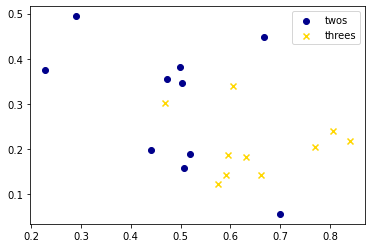

In [11]:
def fourier_descriptors_two(img):
    
    # thresholding with otsu method
    img_thresh = threshold_otsu(img)
    img_otsu = (img > img_thresh).astype(np.uint8)
    
    # extract contours
    contours, _ = cv2.findContours(img_otsu, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    # take the longest contour
    contour = max(contours, key=lambda c: len(c))
    
    # convert to complex representation
    contour = [x[0][0]+x[0][1]*1j for x in contour]
    
    # interpolate to a fixed lenght
    contour = interpolate_contour(contour, 128)
    
    # take the fourier transform
    fourier_transform = np.fft.fft(contour)
    
    # return the magnitude of the second and third terms, normalized by the magnitude of the last term
    return (abs(x)/abs(fourier_transform[-1]) for x in fourier_transform[1:3])


# Plot results

X = []
Y = []
for im in twos_im:
    x, y = fourier_descriptors_two(im)
    X.append(x)
    Y.append(y)
    
plt.scatter(X, Y, marker='o', color='darkblue')

X = []
Y = []
for im in threes_im:
    x, y = fourier_descriptors_two(im)
    X.append(x)
    Y.append(y)
    
plt.scatter(X, Y, marker='x', color='gold')
plt.legend(["twos", "threes"])
plt.show()